In [68]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [69]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/roberta-finetuned"

sys.path.insert(0, ABSOLUTE_PATH)

# Fine-tuning RoBERTa model

In [70]:
import os

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import classification_report

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

## Loading the model and tokenizer

In [71]:
MODEL_NAME = "xlm-roberta-base"
NUM_LABELS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-6
EARLY_STOPPING = 3

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
def freeze_base_model(model):
  """
  Freeze all parameters except the classifier head.
  Only parameters whose names start with "classifier" will require gradients.
  """
  for name, param in model.named_parameters():
    if not name.startswith("classifier"):
      param.requires_grad = False

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Loading the preprocessed data

In [74]:
# Import splits of the dataset (train, val, test)
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv"), sep=";"),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv"), sep=";"),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"), sep=";")
)

# Concatenate split sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


In [75]:
from sklearn.model_selection import train_test_split

print("\nLabel distribution:")
print(train_df['account.type'].value_counts())
print(val_df['account.type'].value_counts())
print(test_df['account.type'].value_counts())

_, train_df = train_test_split(
    train_df,
    train_size=0.95,
    stratify=train_df['account.type'],
    random_state=42
)

_, val_df = train_test_split(
    val_df,
    train_size=0.95,
    stratify=val_df['account.type'],
    random_state=42
)

_, test_df = train_test_split(
    test_df,
    train_size=0.95,
    stratify=test_df['account.type'],
    random_state=42
)

print("\nLabel distribution 2:")
print(train_df['account.type'].value_counts())
print(val_df['account.type'].value_counts())
print(test_df['account.type'].value_counts())


Label distribution:
account.type
human    10358
bot      10354
Name: count, dtype: int64
account.type
human    0.500097
bot      0.499903
Name: proportion, dtype: float64

account.type
bot      1152
human    1150
Name: count, dtype: int64
account.type
bot      0.500434
human    0.499566
Name: proportion, dtype: float64

account.type
bot      1280
human    1278
Name: count, dtype: int64
account.type
bot      0.500391
human    0.499609
Name: proportion, dtype: float64

Label distribution 2:
account.type
human    518
bot      518
Name: count, dtype: int64
account.type
human    0.5
bot      0.5
Name: proportion, dtype: float64

account.type
bot      58
human    58
Name: count, dtype: int64
account.type
bot      0.5
human    0.5
Name: proportion, dtype: float64

account.type
human    64
bot      64
Name: count, dtype: int64
account.type
human    0.5
bot      0.5
Name: proportion, dtype: float64


In [76]:
text_column = 'text' # if 'text_tokens' in train_df.columns else 'text'

X_train = train_df[text_column].values
y_train = (train_df['account.type'] == 'bot').astype(int).values

X_val = val_df[text_column].values
y_val = (val_df['account.type'] == 'bot').astype(int).values

X_test = test_df[text_column].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

train_dataset = TweetDataset(X_train, y_train, tokenizer, 512)
val_dataset = TweetDataset(X_val, y_val, tokenizer, 512)
test_dataset = TweetDataset(X_test, y_test, tokenizer, 512)

## Training the model

In [77]:
training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    # metric_for_best_model=metric_name,
)

# compute_loss - to override one must create custom trainer class
# and override the method compute_loss(self, model, inputs, return_outputs=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(
        AdamW(model.parameters(), lr=LEARNING_RATE), None),
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING)],
)

<ipython-input-77-8e91ac588823>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.680886,0.646552
2,No log,0.605392,0.758621
3,No log,0.560644,0.750000
4,0.624700,0.471355,0.784483
5,0.624700,0.422731,0.775862
6,0.624700,0.409860,0.784483
7,0.624700,0.397736,0.775862
8,0.464300,0.387694,0.758621


In [64]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.6925510168075562,
 'eval_model_preparation_time': 0.0037,
 'eval_accuracy': 0.515625,
 'eval_runtime': 3.0249,
 'eval_samples_per_second': 42.315,
 'eval_steps_per_second': 5.289}

In [65]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [66]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.06      0.11        64
           1       0.51      0.97      0.67        64

    accuracy                           0.52       128
   macro avg       0.59      0.52      0.39       128
weighted avg       0.59      0.52      0.39       128



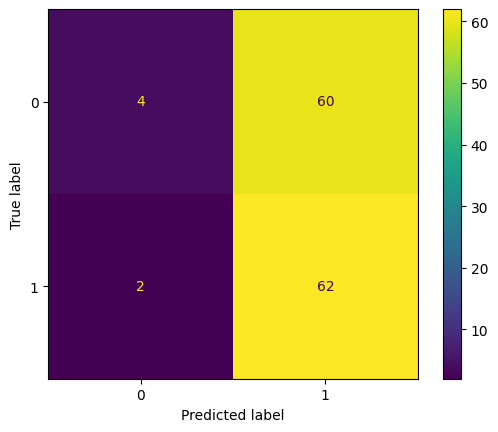

In [67]:
plot_confusion_matrix(y_test, predicted_labels)